In [8]:
import pyfits
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
import os
import copy
from lmfit import Model
from lmfit.models import LorentzianModel
from lmfit.models import ExponentialModel
from lmfit.models import ConstantModel
from lmfit import Parameters, minimize, report_fit, Model
from matplotlib.colors import LinearSegmentedColormap, to_rgb
import seaborn as sns
sns.set_style("dark")
#sns.set_style("darkgrid")
import matplotlib as mpl
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
from uncertainties import ufloat

pd.options.display.max_colwidth = 120
mpl.rc('image', cmap='afmhot')
path= '/home/qd/Schreibtisch/Data/'
file_date = '2019-07-16'
folders = rydlab.analyze_folder(path,filter=False) 
slicer = (slice(15,95),slice(25,275))
binning_scale = 1
folders

Name  \
0                              /home/qd/Schreibtisch/Data/.ipynb_checkpoints   
1                            /home/qd/Schreibtisch/Data/Deltac-Scan-10mWblue   
2            /home/qd/Schreibtisch/Data/Deltac-Scan-10mWblue_averaged_images   
3                  /home/qd/Schreibtisch/Data/Density_vs_EIT_averaged_images   
4                           /home/qd/Schreibtisch/Data/Linescan_with_Binning   
5           /home/qd/Schreibtisch/Data/Linescan_with_Binning_averaged_images   
6                   /home/qd/Schreibtisch/Data/Linescan_withcorrectOP_pabs12   
7   /home/qd/Schreibtisch/Data/Linescan_withcorrectOP_pabs12_averaged_images   
8                                    /home/qd/Schreibtisch/Data/New Analysis   
9                                           /home/qd/Schreibtisch/Data/Older   
10                                    /home/qd/Schreibtisch/Data/__pycache__   
11                                            /home/qd/Schreibtisch/Data/eit   
12                                    /home/qd/Schreibtisch/Data/eit_someone   
13                    /home/qd/Schreibtisch/Data/eit_someone_averaged_images   

    Valid  
0   False  
1    True  
2   False  
3   False  
4    True  
5   False  
6    True  
7   False  
8   False  
9   False  
10  False  
11  False  
12   True  
13  False

In [9]:
path=folders.Name[7]

os.chdir(path)

variables = np.loadtxt( '2019-07-16_variables.dat' )[:,1]

N = len(variables)

print(os.getcwd())

def params_to_dict(params):
    return {key: params[key].value for key in params.keys()}


class Fit2d:
    colors = [(1, 1, 1), to_rgb("#5597C6"), to_rgb("#60BD68"), to_rgb("#FAA43A"), to_rgb("#d37096")]

    c_map_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(c_map_name, colors, N=200)

    @staticmethod
    def _function(x, y):
        pass
    
    def __init__(self, data, x=None, y=None, params=None):
        self.data = data
        if x is None or y is None:
            self.x, self.y = self.get_mesh()

        if params is None:
            model = Model(self._function)
            params = model.make_params()

        self.params = params
        self.fit_object = None

    def fit_data(self, method='LeastSq'):
        fit_object = minimize(self.residuals, self.params, method=method)
        self.fit_object = fit_object
        self.params = fit_object.params

    def residuals(self, p):
        return self.data - self._function([self.x, self.y], **params_to_dict(p))

    def plot(self, ax):
        ax.imshow(self.data, cmap=self.cm)
        ax.contour(self.x, self.y, self._function([self.x, self.y], **params_to_dict(self.params)),
                   5, colors='w', linewidths=0.5)

    def get_mesh(self):
        x = np.arange(0, np.shape(self.data)[1], 1)
        y = np.arange(0, np.shape(self.data)[0], 1)
        return np.meshgrid(x, y)

    def report(self):
        print(report_fit(self.fit_object))


class Fit2dGaussian(Fit2d):
    def __init__(self, data, x=None, y=None, params=None):
        super().__init__(data, x, y, params)

    @staticmethod
    def _function(args, amp=1, cen_x=250, cen_y=50, sig_x=50, sig_y=10, offset=0):
        x, y = args
        return amp * np.exp(-(((cen_x - x) / sig_x) ** 2 + ((cen_y - y) / sig_y) ** 2) / 2.0) + offset


class Fit2d2Gaussian(Fit2d):
    def __init__(self, data, x=None, y=None, params=None):
        super().__init__(data, x, y, params)

    @staticmethod
    def _function(args, amp=1, cen_x=250, cen_y=50, sig_x=50, sig_y=10,
                  amp2=1, cen_x2=250, cen_y2=50, sig_x2=50, sig_y2=10,
                  offset=0):
        x, y = args
        return (amp * np.exp(-(((cen_x - x) / sig_x) ** 2 + ((cen_y - y) / sig_y) ** 2) / 2.0)
                + amp2 * np.exp(-(((cen_x2 - x) / sig_x2) ** 2 + ((cen_y2 - y) / sig_y2) ** 2) / 2.0)
                + offset)


def fitsopen(n,bg):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x])/(hdulist[0].data[1,y,x]))

    hdulist.close()
    return data-bg

def fitsopen_bg(n,bg):
    hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
    images = hdulist[0].data
    absorb = images[0]
    no_absorb = images[1]
    div = (absorb-bg)/(no_absorb-bg)
    
    div = div[slicer]
    div = -np.log(div)
    div = np.nan_to_num(div)
    return div

def fitsopen_std(n):
    os.chdir(path+'/std')
    file_date = '2019-07-16'
    hdulist = pyfits.open(file_date+str("_")+str(n).zfill(3)+'.fts')
    images = hdulist[0].data
    absorb_weights = 1/images[0]
    n#o_absorb_weights = 1/images[1]
    #div = (absorb-bg)/(no_absorb-bg)
    
    absorb_weights = absorb_weights[slicer]
    #absorb_weights = -np.log(absorb_weights)
    absorb_weights=absorb_weights/np.mean(absorb_weights)
    #absorb_weights = np.nan_to_num(absorb_weights)
    os.chdir(path)
    file_date = '2019-07-16'
    return absorb_weights

def twoD_Gaussian(xy_mesh, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xy_mesh
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()


def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()


def make_background(N):
    list_bg=list()
    for n in range(0,N):
        hdulist = pyfits.open(file_date+str("_")+str(n).zfill(2)+'.fts')
        list_bg.append(hdulist[0].data[2])
        hdulist.close()
    bg_mean = np.array(list_bg).mean(axis=0)
    bg_std = np.array(list_bg).std(axis=0)
    return bg_mean,bg_std
        



def LZ(x,amplitude,W,x0,c):
    return amplitude*np.exp(2*np.pi*W**2/(x-x0))+c

/home/qd/Schreibtisch/Data/Linescan_withcorrectOP_pabs12_averaged_images


[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 250
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.3016120
    reduced chi-square = 0.00231624
    Akaike info crit   = -121346.216
    Bayesian info crit = -121267.181
[[Variables]]
    amplitude1:  0.13702526 +/- 0.00108857 (0.79%) (init = 0.1)
    xo1:         31.8203562 +/- 0.44661889 (1.40%) (init = 30)
    yo1:         121.208998 +/- 0.48370629 (0.40%) (init = 120)
    sigma_x1:    45.2602785 +/- 0.86047375 (1.90%) (init = 43)
    sigma_y1:    79.0826234 +/- 0.62830313 (0.79%) (init = 80)
    theta1:      0.00751408 +/- 0.01079322 (143.64%) (init = 0)
    amplitude2:  0.01179425 +/- 0.00372505 (31.58%) (init = 0)
    xo2:         35.0012984 +/- 2.57031082 (7.34%) (init = 38)
    yo2:         136.000000 +/- 2.85720556 (2.10%) (init = 133)
    sigma_x2:    9.99998357 +/- 0.79419905 (7.94%) (init = 2)
    sigma_y2:    9.99998357 +/- 0

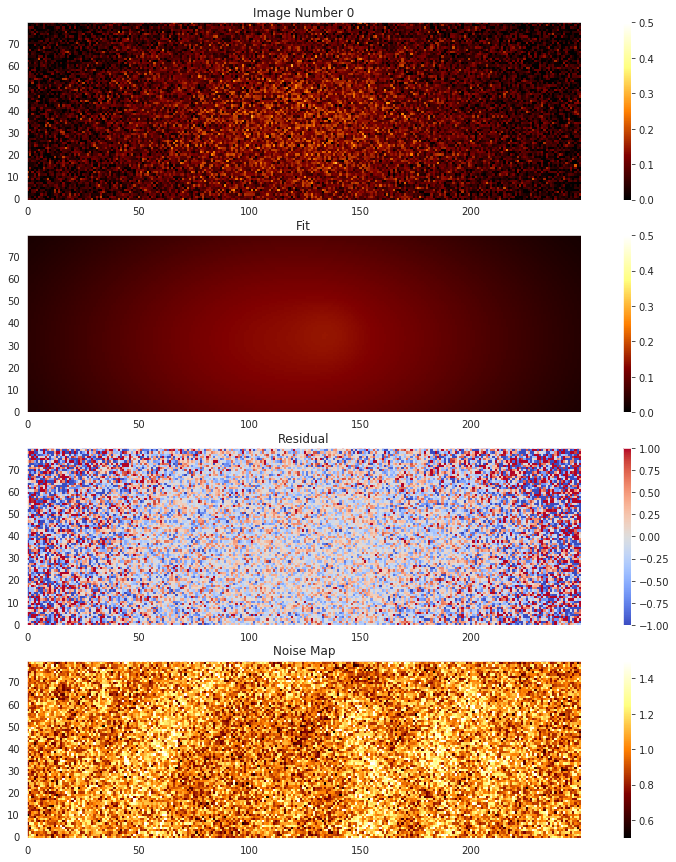

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 115
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.1272803
    reduced chi-square = 0.00230752
    Akaike info crit   = -121421.660
    Bayesian info crit = -121342.625
[[Variables]]
    amplitude1:  0.14947747 +/- 0.00112667 (0.75%) (init = 0.1)
    xo1:         32.0082684 +/- 0.37329518 (1.17%) (init = 30)
    yo1:         120.047713 +/- 0.43860098 (0.37%) (init = 120)
    sigma_x1:    42.8626959 +/- 0.69174852 (1.61%) (init = 43)
    sigma_y1:    78.4164563 +/- 0.58326894 (0.74%) (init = 80)
    theta1:     -0.00472750 +/- 0.00877154 (185.54%) (init = 0)
    amplitude2:  0.01419386 +/- 0.00368641 (25.97%) (init = 0)
    xo2:         35.0004496 +/- 5.79288749 (16.55%) (init = 38)
    yo2:         130.210787 +/- 2.44796794 (1.88%) (init = 133)
    sigma_x2:    9.99991568 +/- 29.6228426 (296.23%) (init = 2)
    sigma_y2:    9.99991568 +/

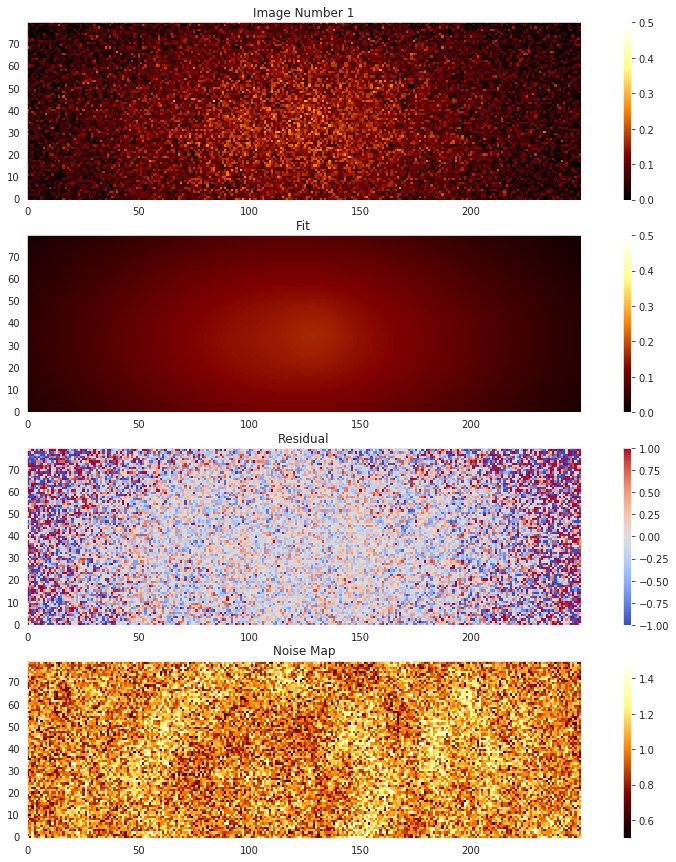

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.7937424
    reduced chi-square = 0.00234086
    Akaike info crit   = -121134.761
    Bayesian info crit = -121055.726
[[Variables]]
    amplitude1:  0.16623507 +/- 8.6634e-04 (0.52%) (init = 0.1)
    xo1:         31.9026727 +/- 0.33356299 (1.05%) (init = 30)
    yo1:         121.874584 +/- 0.39052715 (0.32%) (init = 120)
    sigma_x1:    43.3804468 +/- 0.61027578 (1.41%) (init = 43)
    sigma_y1:    78.3338802 +/- 0.47263421 (0.60%) (init = 80)
    theta1:     -0.01574679 +/- 0.00820867 (52.13%) (init = 0)
    amplitude2:  0.03852993 +/- 0.00959744 (24.91%) (init = 0)
    xo2:         36.8533175 +/- 0.94527325 (2.56%) (init = 38)
    yo2:         130.705196 +/- 0.96466059 (0.74%) (init = 133)
    sigma_x2:    3.76375827 +/- 0.68570111 (18.22%) (init = 2)
    sigma_y2:    3.76375827 +/- 0.

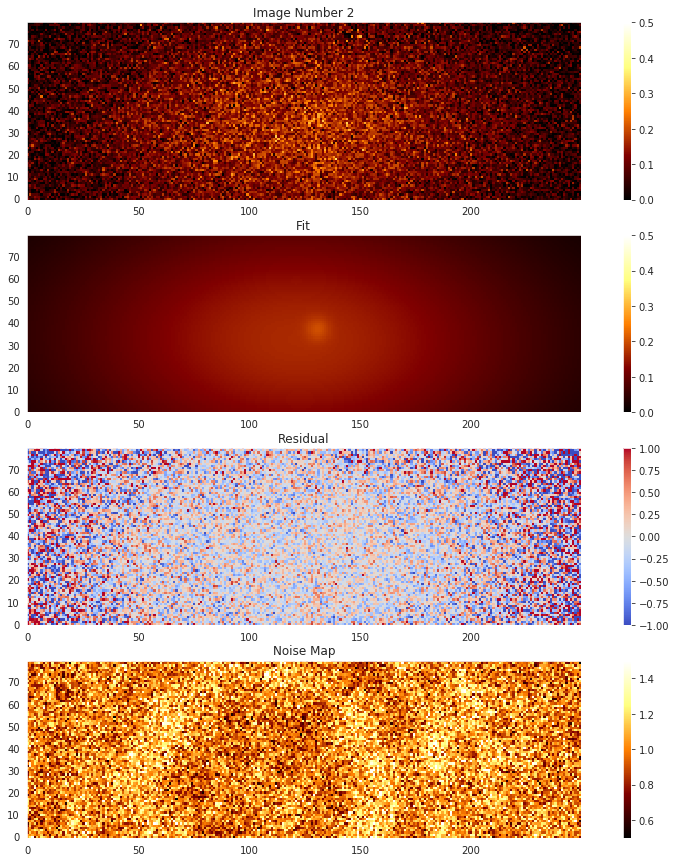

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 194
    # data points      = 20000
    # variables        = 10
    chi-square         = 45.3802579
    reduced chi-square = 0.00227015
    Akaike info crit   = -121748.208
    Bayesian info crit = -121669.173
[[Variables]]
    amplitude1:  0.14872168 +/- 8.1740e-04 (0.55%) (init = 0.1)
    xo1:         32.1304506 +/- 0.35482714 (1.10%) (init = 30)
    yo1:         119.352208 +/- 0.43363614 (0.36%) (init = 120)
    sigma_x1:    42.8585764 +/- 0.64171722 (1.50%) (init = 43)
    sigma_y1:    79.1560411 +/- 0.52623524 (0.66%) (init = 80)
    theta1:      0.01438194 +/- 0.00860107 (59.80%) (init = 0)
    amplitude2: -0.01207816 +/- 0.01767571 (146.34%) (init = 0)
    xo2:         37.2309189 +/- 2.89571020 (7.78%) (init = 38)
    yo2:         130.000000 +/- 2.98321451 (2.29%) (init = 133)
    sigma_x2:    2.00000001 +/- 2.11401472 (105.70%) (init = 2)
    sigma_y2:    2.00000001 +/-

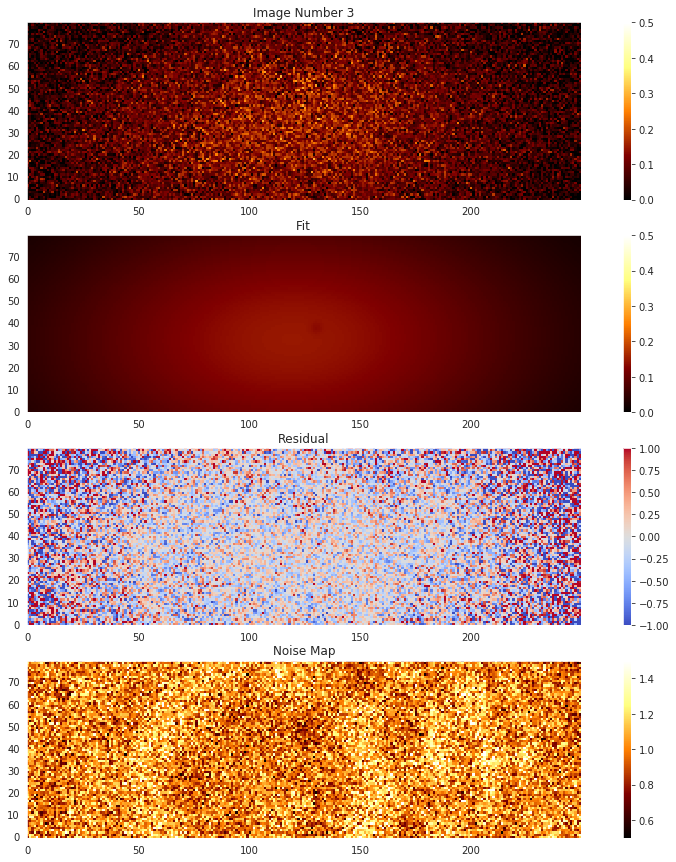

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 177
    # data points      = 20000
    # variables        = 10
    chi-square         = 48.3691315
    reduced chi-square = 0.00241967
    Akaike info crit   = -120472.514
    Bayesian info crit = -120393.480
[[Variables]]
    amplitude1:  0.17350046 +/- 8.5814e-04 (0.49%) (init = 0.1)
    xo1:         32.4264260 +/- 0.30499507 (0.94%) (init = 30)
    yo1:         120.353707 +/- 0.37904439 (0.31%) (init = 120)
    sigma_x1:    42.1212723 +/- 0.54685493 (1.30%) (init = 43)
    sigma_y1:    77.9947221 +/- 0.45410133 (0.58%) (init = 80)
    theta1:     -0.01240645 +/- 0.00748559 (60.34%) (init = 0)
    amplitude2:  0.04196456 +/- 0.01514699 (36.09%) (init = 0)
    xo2:         40.4163725 +/- 0.88421701 (2.19%) (init = 38)
    yo2:         132.140540 +/- 0.88789968 (0.67%) (init = 133)
    sigma_x2:    2.14299764 +/- 0.56074108 (26.17%) (init = 2)
    sigma_y2:    2.14299764 +/- 0

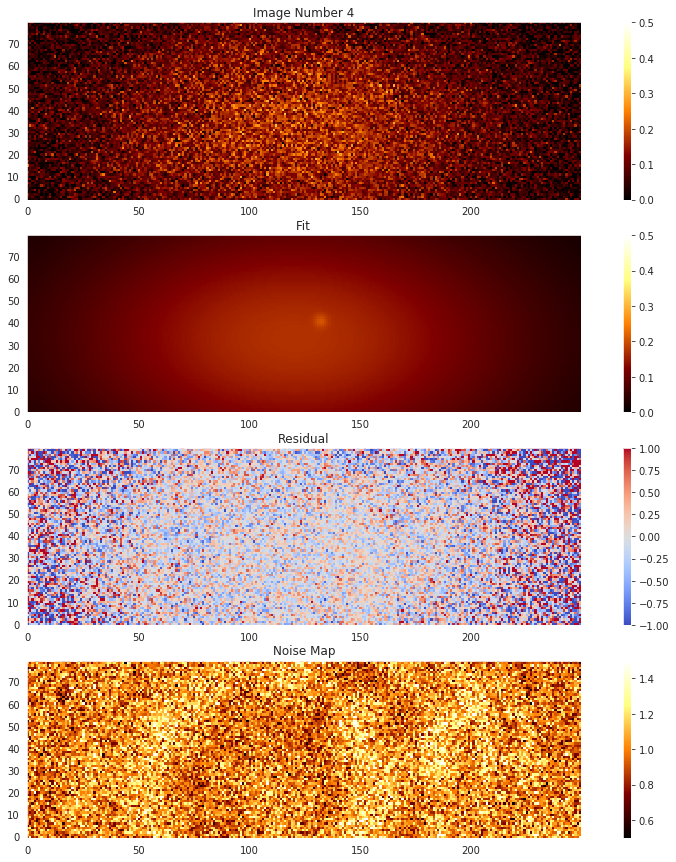

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.6751401
    reduced chi-square = 0.00233492
    Akaike info crit   = -121185.517
    Bayesian info crit = -121106.482
[[Variables]]
    amplitude1:  0.17112965 +/- 8.2315e-04 (0.48%) (init = 0.1)
    xo1:         32.2289395 +/- 0.30552993 (0.95%) (init = 30)
    yo1:         121.103975 +/- 0.39147836 (0.32%) (init = 120)
    sigma_x1:    42.6355317 +/- 0.55053730 (1.29%) (init = 43)
    sigma_y1:    81.0349326 +/- 0.48228324 (0.60%) (init = 80)
    theta1:     -0.00229366 +/- 0.00716587 (312.42%) (init = 0)
    amplitude2: -0.05758764 +/- 0.01850901 (32.14%) (init = 0)
    xo2:         37.3834202 +/- 0.66434329 (1.78%) (init = 38)
    yo2:         135.999950 +/- 1.02103758 (0.75%) (init = 133)
    sigma_x2:    2.00018461 +/- 0.14596159 (7.30%) (init = 2)
    sigma_y2:    2.00018461 +/- 0

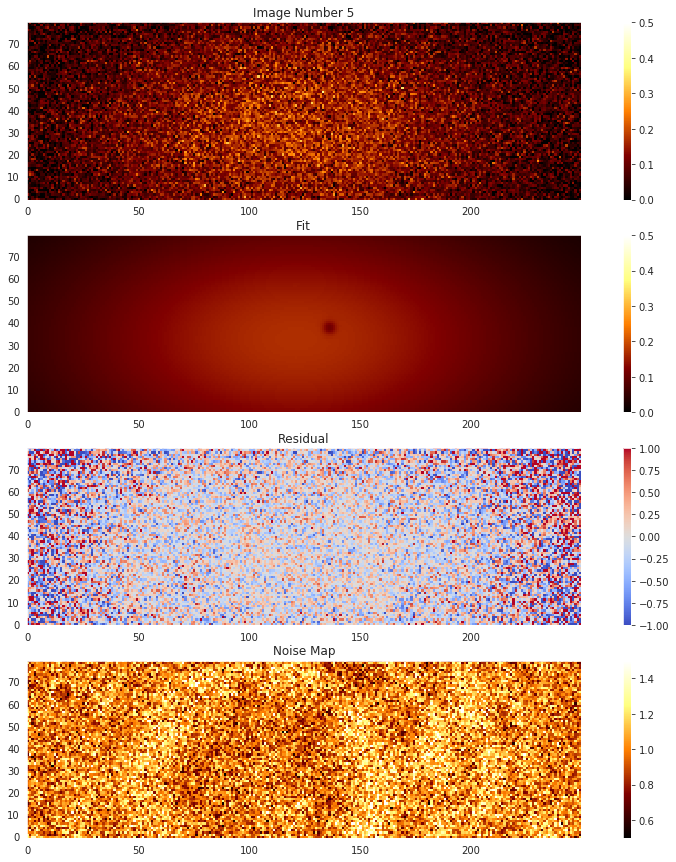

/home/qd/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

divide by zero encountered in true_divide



[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.8451604
    reduced chi-square = 0.00234343
    Akaike info crit   = -121112.797
    Bayesian info crit = -121033.762
[[Variables]]
    amplitude1:  0.18443934 +/- 9.2685e-04 (0.50%) (init = 0.1)
    xo1:         31.7432235 +/- 0.31781064 (1.00%) (init = 30)
    yo1:         121.693829 +/- 0.35110615 (0.29%) (init = 120)
    sigma_x1:    44.2489250 +/- 0.59376529 (1.34%) (init = 43)
    sigma_y1:    78.0975817 +/- 0.43119689 (0.55%) (init = 80)
    theta1:     -0.00507121 +/- 0.00780353 (153.88%) (init = 0)
    amplitude2: -0.04779284 +/- 0.00626618 (13.11%) (init = 0)
    xo2:         39.1268938 +/- 0.77819496 (1.99%) (init = 38)
    yo2:         133.199189 +/- 0.74938362 (0.56%) (init = 133)
    sigma_x2:    5.87442425 +/- 0.57438378 (9.78%) (init = 2)
    sigma_y2:    5.87442425 +/- 0

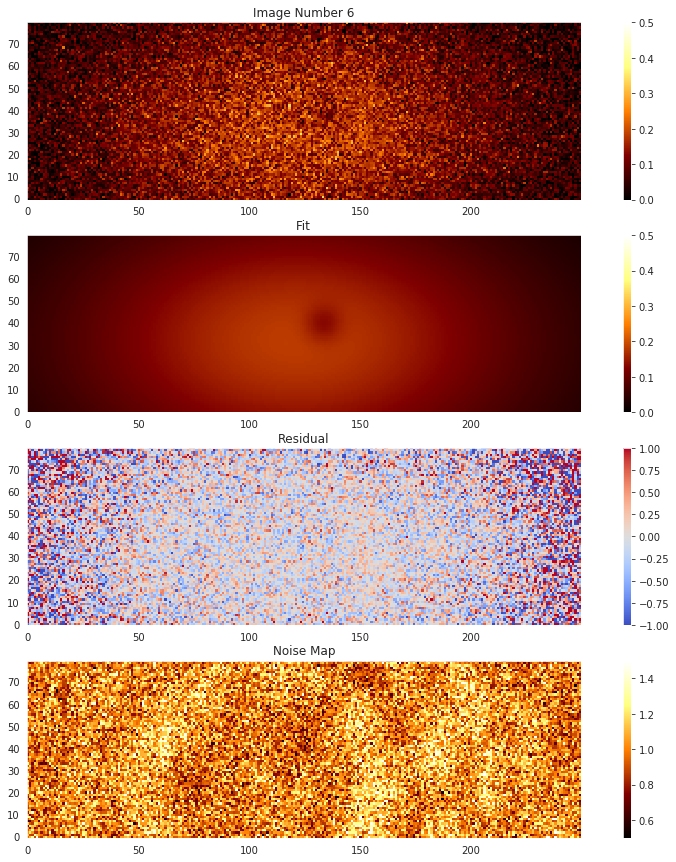

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 20000
    # variables        = 10
    chi-square         = 47.5533817
    reduced chi-square = 0.00237886
    Akaike info crit   = -120812.693
    Bayesian info crit = -120733.658
[[Variables]]
    amplitude1:  0.17899284 +/- 0.00101724 (0.57%) (init = 0.1)
    xo1:         31.6534222 +/- 0.32225310 (1.02%) (init = 30)
    yo1:         116.664051 +/- 0.37682067 (0.32%) (init = 120)
    sigma_x1:    43.4419260 +/- 0.60016038 (1.38%) (init = 43)
    sigma_y1:    79.0302570 +/- 0.47362302 (0.60%) (init = 80)
    theta1:      0.00639116 +/- 0.00756134 (118.31%) (init = 0)
    amplitude2: -0.08145004 +/- 0.00456895 (5.61%) (init = 0)
    xo2:         37.3298047 +/- 0.45387211 (1.22%) (init = 38)
    yo2:         132.051184 +/- 0.45910441 (0.35%) (init = 133)
    sigma_x2:    7.90505484 +/- 0.35488925 (4.49%) (init = 2)
    sigma_y2:    7.90505484 +/- 0.

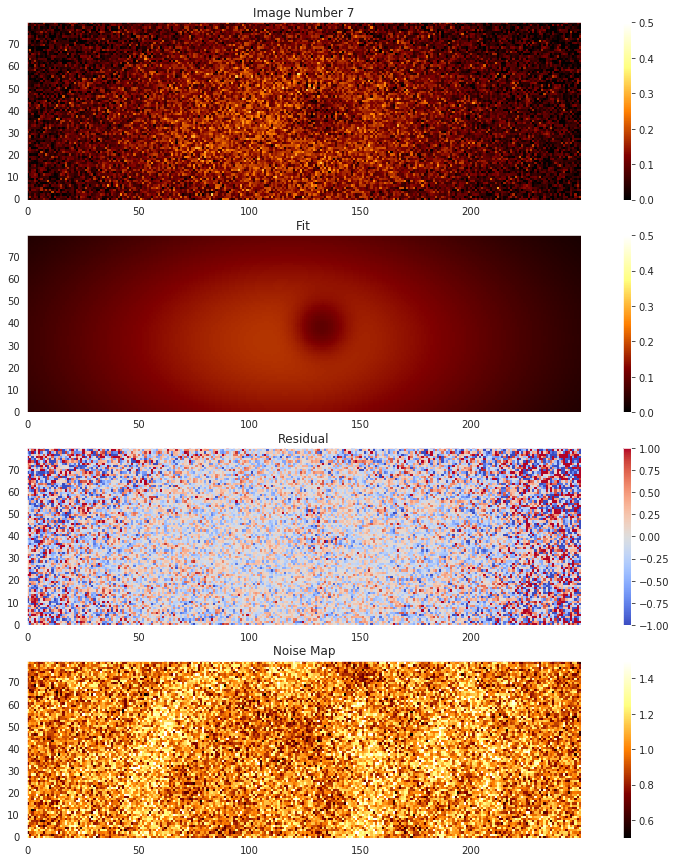

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.7359726
    reduced chi-square = 0.00233797
    Akaike info crit   = -121159.468
    Bayesian info crit = -121080.433
[[Variables]]
    amplitude1:  0.18579971 +/- 0.00106102 (0.57%) (init = 0.1)
    xo1:         31.9785334 +/- 0.30997849 (0.97%) (init = 30)
    yo1:         120.583924 +/- 0.35493484 (0.29%) (init = 120)
    sigma_x1:    43.6848076 +/- 0.58490376 (1.34%) (init = 43)
    sigma_y1:    79.0534116 +/- 0.46403364 (0.59%) (init = 80)
    theta1:     -0.02226619 +/- 0.00738551 (33.17%) (init = 0)
    amplitude2: -0.06974395 +/- 0.00413094 (5.92%) (init = 0)
    xo2:         38.3054887 +/- 0.52453562 (1.37%) (init = 38)
    yo2:         130.547605 +/- 0.53840125 (0.41%) (init = 133)
    sigma_x2:    8.99188324 +/- 0.43162976 (4.80%) (init = 2)
    sigma_y2:    8.99188324 +/- 0.4

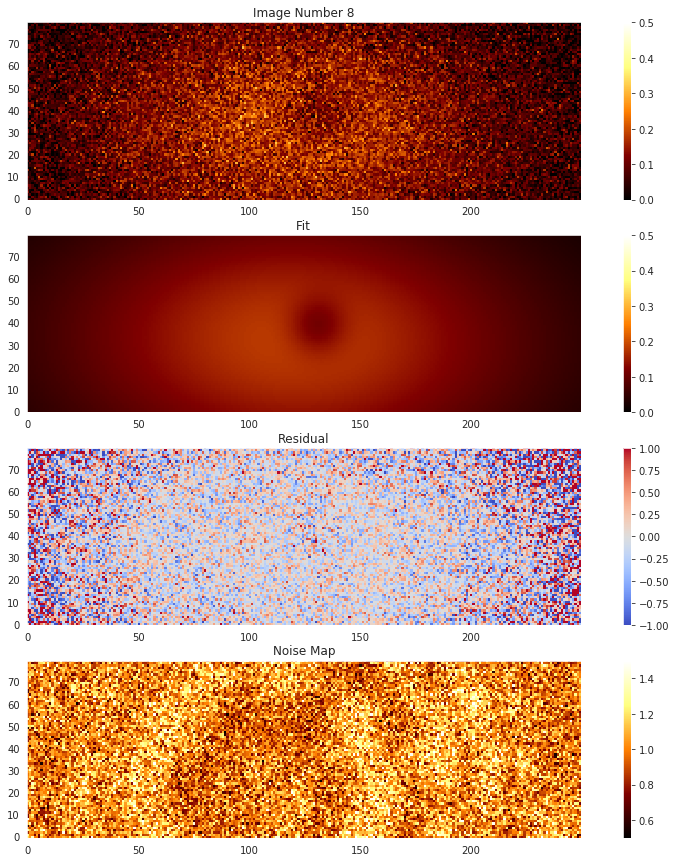

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 20000
    # variables        = 10
    chi-square         = 48.0262585
    reduced chi-square = 0.00240251
    Akaike info crit   = -120614.793
    Bayesian info crit = -120535.758
[[Variables]]
    amplitude1:  0.19295311 +/- 9.8968e-04 (0.51%) (init = 0.1)
    xo1:         31.9943114 +/- 0.29745059 (0.93%) (init = 30)
    yo1:         119.949516 +/- 0.34813980 (0.29%) (init = 120)
    sigma_x1:    43.7717485 +/- 0.56024119 (1.28%) (init = 43)
    sigma_y1:    79.8457073 +/- 0.44294112 (0.55%) (init = 80)
    theta1:      0.00915422 +/- 0.00702117 (76.70%) (init = 0)
    amplitude2: -0.06057553 +/- 0.00514601 (8.50%) (init = 0)
    xo2:         38.4082185 +/- 0.61164401 (1.59%) (init = 38)
    yo2:         130.087222 +/- 0.60164961 (0.46%) (init = 133)
    sigma_x2:    7.09165862 +/- 0.47388599 (6.68%) (init = 2)
    sigma_y2:    7.09165862 +/- 0.4

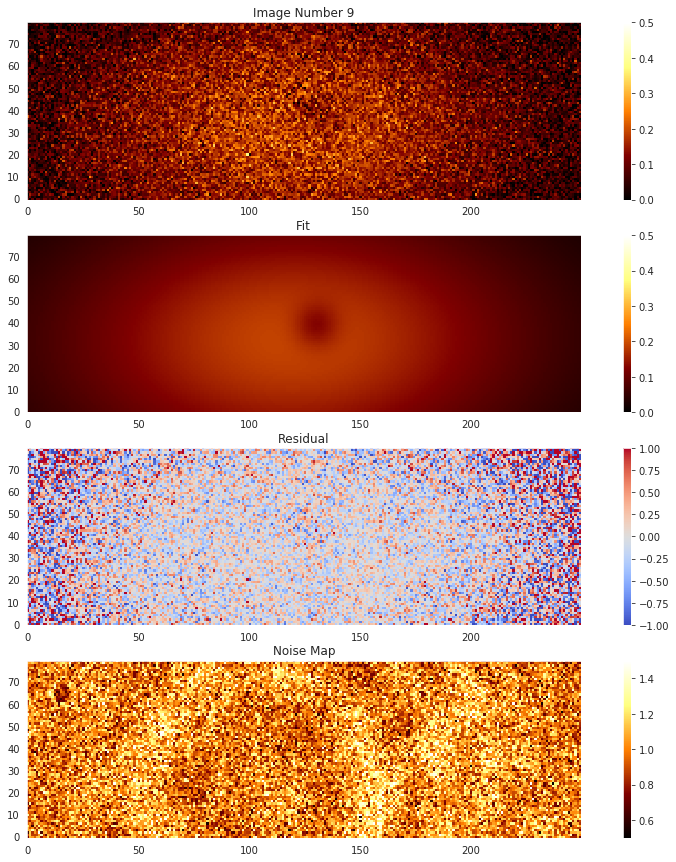

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 20000
    # variables        = 10
    chi-square         = 47.7067067
    reduced chi-square = 0.00238653
    Akaike info crit   = -120748.311
    Bayesian info crit = -120669.276
[[Variables]]
    amplitude1:  0.19814057 +/- 9.5975e-04 (0.48%) (init = 0.1)
    xo1:         31.3409484 +/- 0.29236990 (0.93%) (init = 30)
    yo1:         121.837898 +/- 0.34001235 (0.28%) (init = 120)
    sigma_x1:    43.6789089 +/- 0.53816560 (1.23%) (init = 43)
    sigma_y1:    80.1250850 +/- 0.43140144 (0.54%) (init = 80)
    theta1:     -8.1719e-04 +/- 0.00676932 (828.37%) (init = 0)
    amplitude2: -0.03999980 +/- 0.00560512 (14.01%) (init = 0)
    xo2:         36.8162763 +/- 0.90713878 (2.46%) (init = 38)
    yo2:         130.000005 +/- 0.55757764 (0.43%) (init = 133)
    sigma_x2:    6.55590543 +/- 0.69934850 (10.67%) (init = 2)
    sigma_y2:    6.55590543 +/- 0

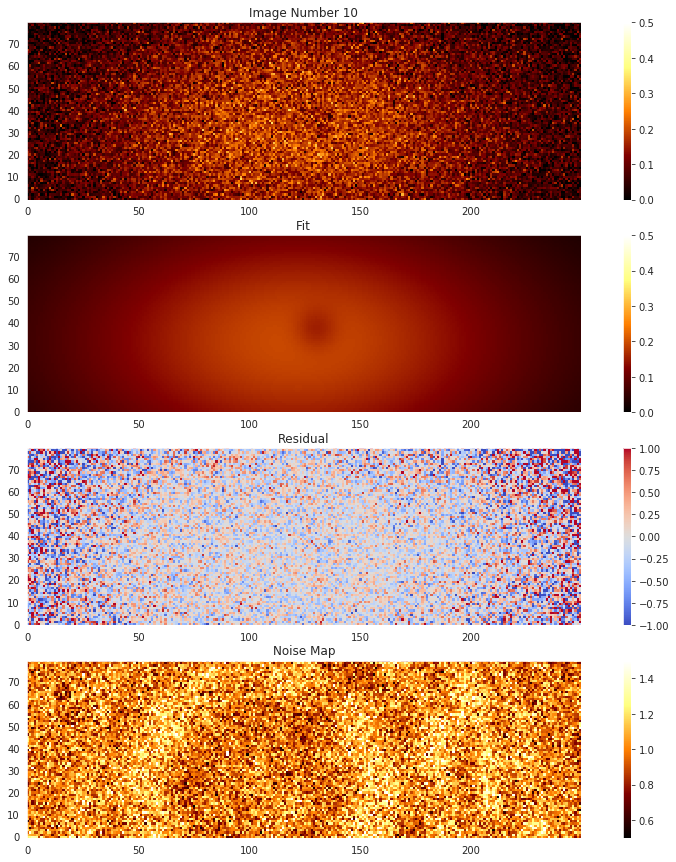

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 20000
    # variables        = 10
    chi-square         = 48.1786679
    reduced chi-square = 0.00241014
    Akaike info crit   = -120551.424
    Bayesian info crit = -120472.389
[[Variables]]
    amplitude1:  0.18871242 +/- 8.3201e-04 (0.44%) (init = 0.1)
    xo1:         31.2945871 +/- 0.31605055 (1.01%) (init = 30)
    yo1:         117.375808 +/- 0.35584045 (0.30%) (init = 120)
    sigma_x1:    44.6743387 +/- 0.57759763 (1.29%) (init = 43)
    sigma_y1:    79.8080766 +/- 0.43060259 (0.54%) (init = 80)
    theta1:     -0.00953022 +/- 0.00761890 (79.94%) (init = 0)
    amplitude2:  0.00532285 +/- 0.01716059 (322.39%) (init = 0)
    xo2:         35.0018017 +/- 6.16323968 (17.61%) (init = 38)
    yo2:         130.000002 +/- 0.37785230 (0.29%) (init = 133)
    sigma_x2:    2.00000000 +/- 1.60251462 (80.13%) (init = 2)
    sigma_y2:    2.00000000 +/-

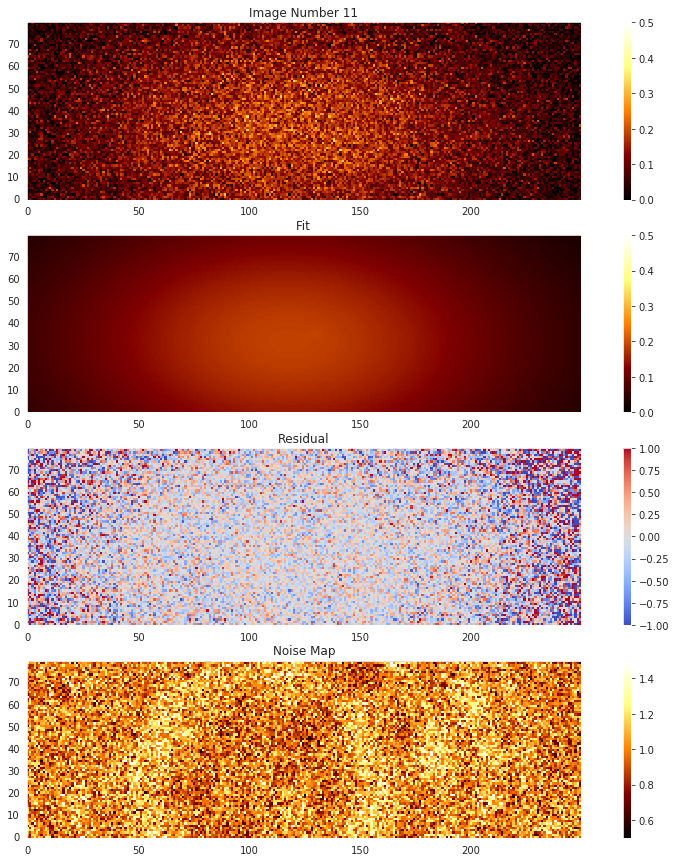

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 215
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.7586241
    reduced chi-square = 0.00233910
    Akaike info crit   = -121149.777
    Bayesian info crit = -121070.742
[[Variables]]
    amplitude1:  0.19511726 +/- 8.4210e-04 (0.43%) (init = 0.1)
    xo1:         31.6986135 +/- 0.29035055 (0.92%) (init = 30)
    yo1:         118.205329 +/- 0.33585371 (0.28%) (init = 120)
    sigma_x1:    43.8772954 +/- 0.52977408 (1.21%) (init = 43)
    sigma_y1:    78.9525944 +/- 0.40759938 (0.52%) (init = 80)
    theta1:     -0.01316391 +/- 0.00710105 (53.94%) (init = 0)
    amplitude2:  0.01869256 +/- 0.01152369 (61.65%) (init = 0)
    xo2:         40.9999569 +/- 0.60396075 (1.47%) (init = 38)
    yo2:         130.000045 +/- 0.43716056 (0.34%) (init = 133)
    sigma_x2:    3.03511799 +/- 1.34820512 (44.42%) (init = 2)
    sigma_y2:    3.03511799 +/- 1

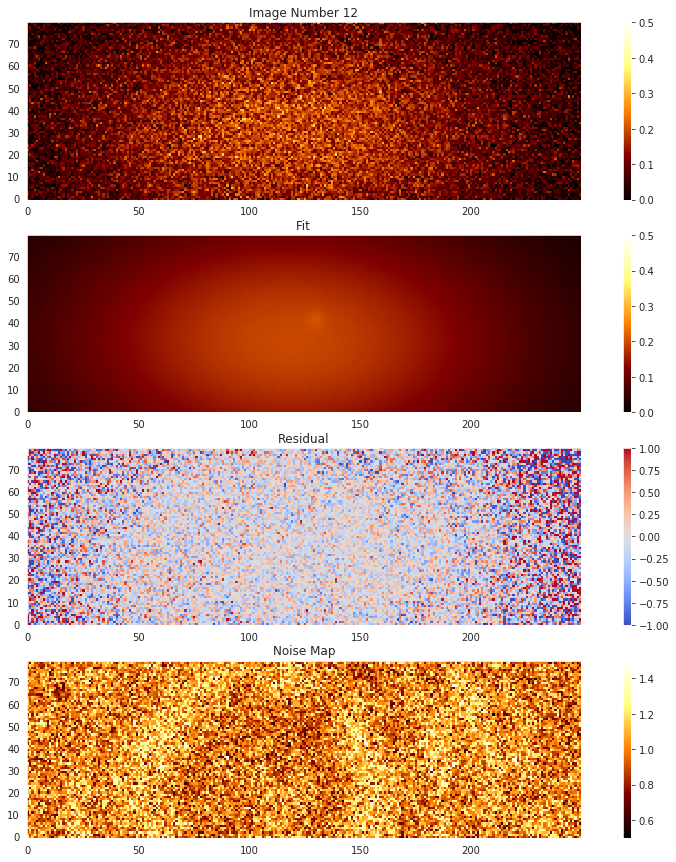

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 204
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.4233089
    reduced chi-square = 0.00232233
    Akaike info crit   = -121293.717
    Bayesian info crit = -121214.683
[[Variables]]
    amplitude1:  0.18574956 +/- 0.00105444 (0.57%) (init = 0.1)
    xo1:         32.5907588 +/- 0.30436210 (0.93%) (init = 30)
    yo1:         119.053953 +/- 0.35364039 (0.30%) (init = 120)
    sigma_x1:    43.9487882 +/- 0.58824572 (1.34%) (init = 43)
    sigma_y1:    78.1432941 +/- 0.44796327 (0.57%) (init = 80)
    theta1:     -0.02129233 +/- 0.00762887 (35.83%) (init = 0)
    amplitude2:  0.01244522 +/- 0.00413428 (33.22%) (init = 0)
    xo2:         35.0001016 +/- 2.87161931 (8.20%) (init = 38)
    yo2:         135.999999 +/- 0.24838456 (0.18%) (init = 133)
    sigma_x2:    9.05868964 +/- 2.48783074 (27.46%) (init = 2)
    sigma_y2:    9.05868964 +/- 2

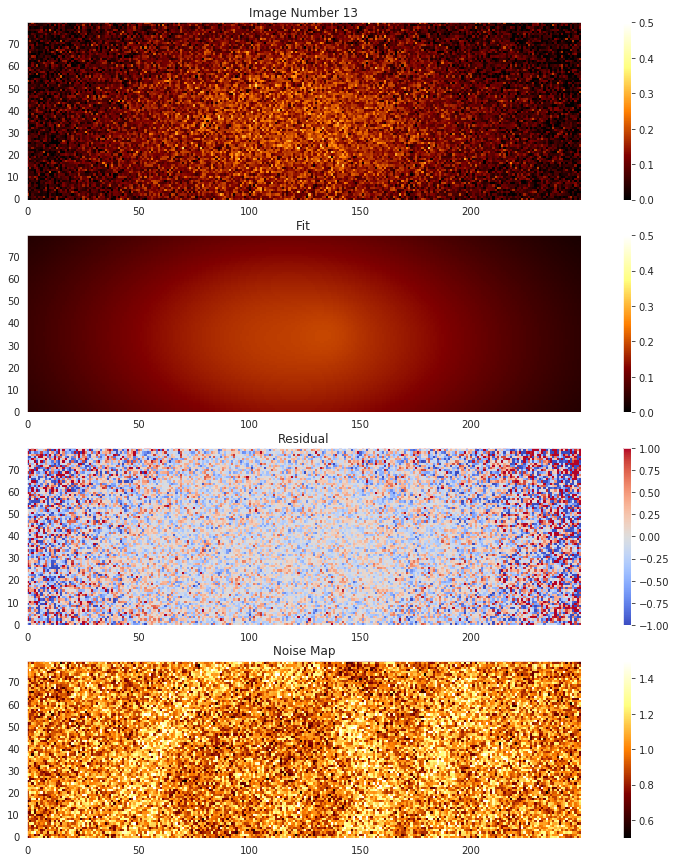

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 107
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.0667135
    reduced chi-square = 0.00230449
    Akaike info crit   = -121447.938
    Bayesian info crit = -121368.903
[[Variables]]
    amplitude1:  0.17255965 +/- 8.3837e-04 (0.49%) (init = 0.1)
    xo1:         31.5776481 +/- 0.32708221 (1.04%) (init = 30)
    yo1:         119.298226 +/- 0.37648489 (0.32%) (init = 120)
    sigma_x1:    43.8190287 +/- 0.59372353 (1.35%) (init = 43)
    sigma_y1:    78.9170013 +/- 0.45484019 (0.58%) (init = 80)
    theta1:     -0.01190683 +/- 0.00792573 (66.56%) (init = 0)
    amplitude2:  0.03238254 +/- 0.01201824 (37.11%) (init = 0)
    xo2:         38.4941411 +/- 1.09035942 (2.83%) (init = 38)
    yo2:         130.000000 +/- 0.05074287 (0.04%) (init = 133)
    sigma_x2:    2.90784682 +/- 0.79368175 (27.29%) (init = 2)
    sigma_y2:    2.90784682 +/- 0

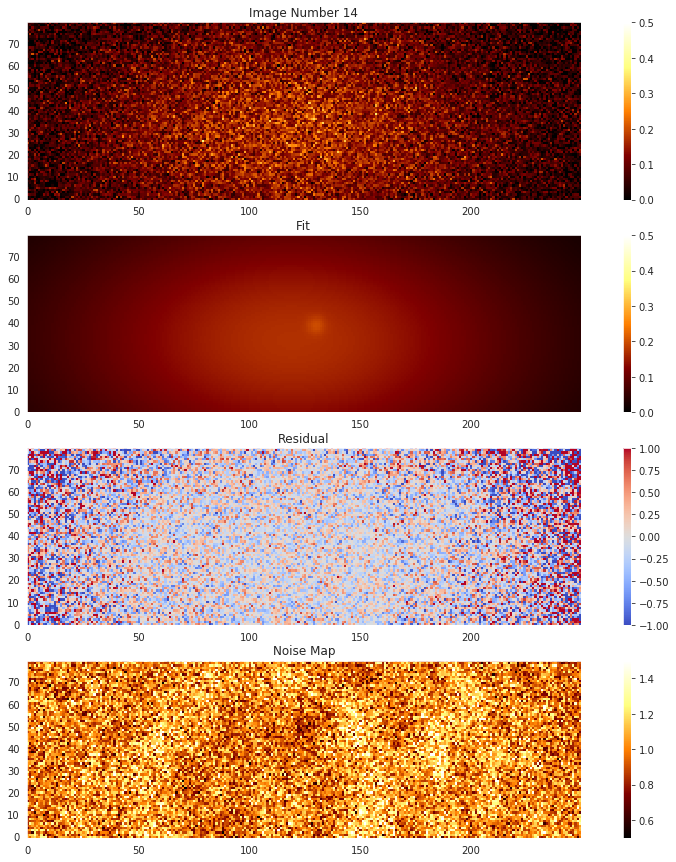

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.6926124
    reduced chi-square = 0.00233580
    Akaike info crit   = -121178.032
    Bayesian info crit = -121098.997
[[Variables]]
    amplitude1:  0.18660069 +/- 8.3656e-04 (0.45%) (init = 0.1)
    xo1:         31.2228137 +/- 0.30673258 (0.98%) (init = 30)
    yo1:         121.324740 +/- 0.35045277 (0.29%) (init = 120)
    sigma_x1:    43.8210517 +/- 0.55163077 (1.26%) (init = 43)
    sigma_y1:    78.9612447 +/- 0.42254199 (0.54%) (init = 80)
    theta1:     -4.3552e-04 +/- 0.00735392 (1688.52%) (init = 0)
    amplitude2:  0.02951240 +/- 0.01503992 (50.96%) (init = 0)
    xo2:         35.0017563 +/- 1.29229771 (3.69%) (init = 38)
    yo2:         130.601494 +/- 1.24957292 (0.96%) (init = 133)
    sigma_x2:    2.48299816 +/- 0.91910698 (37.02%) (init = 2)
    sigma_y2:    2.48299816 +/-

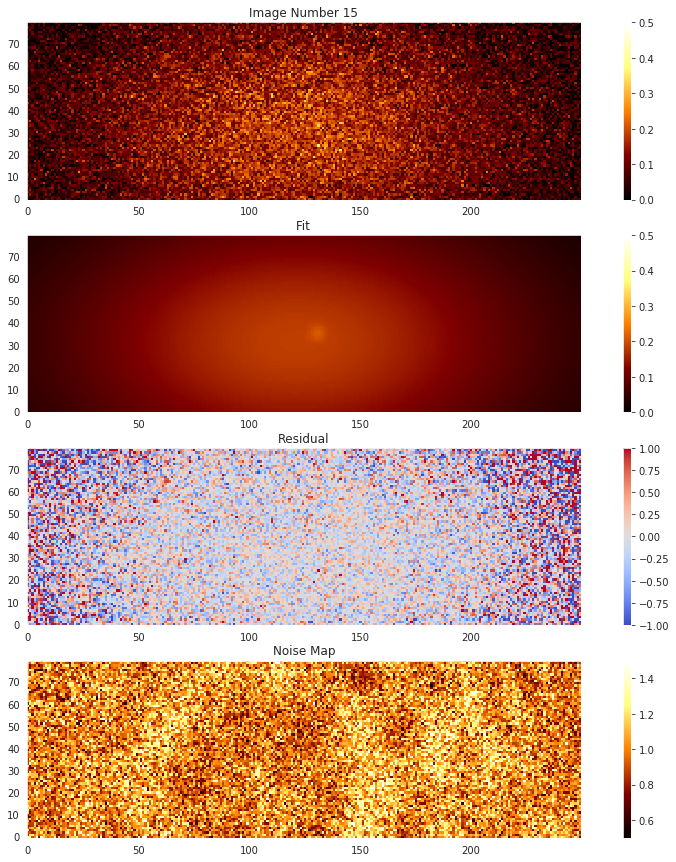

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 112
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.6970611
    reduced chi-square = 0.00233602
    Akaike info crit   = -121176.126
    Bayesian info crit = -121097.092
[[Variables]]
    amplitude1:  0.18604432 +/- 8.4308e-04 (0.45%) (init = 0.1)
    xo1:         32.4415039 +/- 0.28567610 (0.88%) (init = 30)
    yo1:         122.949492 +/- 0.34716939 (0.28%) (init = 120)
    sigma_x1:    42.7693924 +/- 0.51808734 (1.21%) (init = 43)
    sigma_y1:    78.2447986 +/- 0.41732561 (0.53%) (init = 80)
    theta1:     -0.01844020 +/- 0.00708657 (38.43%) (init = 0)
    amplitude2:  0.06341903 +/- 0.01660539 (26.18%) (init = 0)
    xo2:         38.8223427 +/- 0.59125570 (1.52%) (init = 38)
    yo2:         131.563404 +/- 0.58781503 (0.45%) (init = 133)
    sigma_x2:    2.14044642 +/- 0.39380962 (18.40%) (init = 2)
    sigma_y2:    2.14044642 +/- 0

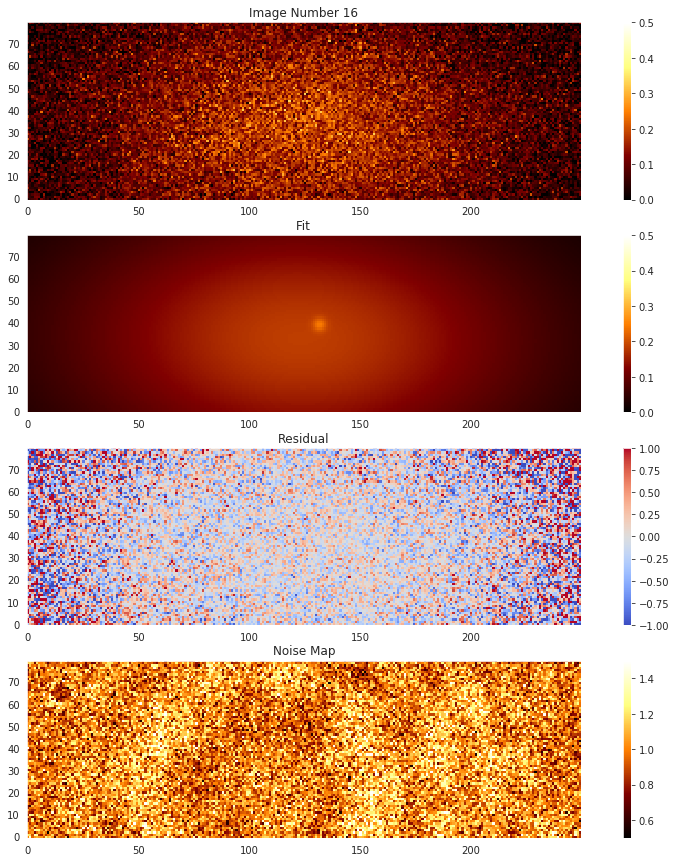

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 20000
    # variables        = 10
    chi-square         = 45.1661603
    reduced chi-square = 0.00225944
    Akaike info crit   = -121842.788
    Bayesian info crit = -121763.753
[[Variables]]
    amplitude1:  0.15778059 +/- 9.2872e-04 (0.59%) (init = 0.1)
    xo1:         31.7811288 +/- 0.34966876 (1.10%) (init = 30)
    yo1:         118.457543 +/- 0.41514670 (0.35%) (init = 120)
    sigma_x1:    43.5047320 +/- 0.65127845 (1.50%) (init = 43)
    sigma_y1:    79.4231920 +/- 0.51354836 (0.65%) (init = 80)
    theta1:      0.00408157 +/- 0.00832289 (203.91%) (init = 0)
    amplitude2:  0.01815527 +/- 0.00571973 (31.50%) (init = 0)
    xo2:         35.0000063 +/- 1.02792054 (2.94%) (init = 38)
    yo2:         135.494695 +/- 2.12344550 (1.57%) (init = 133)
    sigma_x2:    6.63303803 +/- 1.56620281 (23.61%) (init = 2)
    sigma_y2:    6.63303803 +/- 

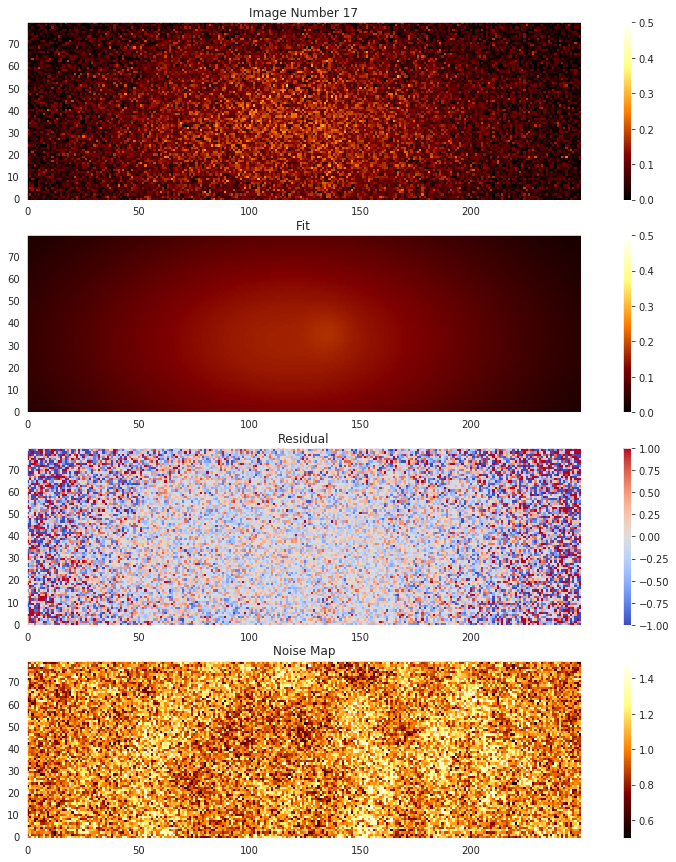

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 202
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.0157643
    reduced chi-square = 0.00230194
    Akaike info crit   = -121470.070
    Bayesian info crit = -121391.035
[[Variables]]
    amplitude1:  0.14877103 +/- 8.7831e-04 (0.59%) (init = 0.1)
    xo1:         31.9639416 +/- 0.35982866 (1.13%) (init = 30)
    yo1:         121.413607 +/- 0.44364256 (0.37%) (init = 120)
    sigma_x1:    43.0001255 +/- 0.66082421 (1.54%) (init = 43)
    sigma_y1:    80.5176675 +/- 0.55635679 (0.69%) (init = 80)
    theta1:     -0.01479615 +/- 0.00846720 (57.23%) (init = 0)
    amplitude2:  0.02003895 +/- 0.00739512 (36.90%) (init = 0)
    xo2:         37.4669743 +/- 1.79985908 (4.80%) (init = 38)
    yo2:         130.000030 +/- 1.32908153 (1.02%) (init = 133)
    sigma_x2:    4.67494713 +/- 1.30998450 (28.02%) (init = 2)
    sigma_y2:    4.67494713 +/- 1

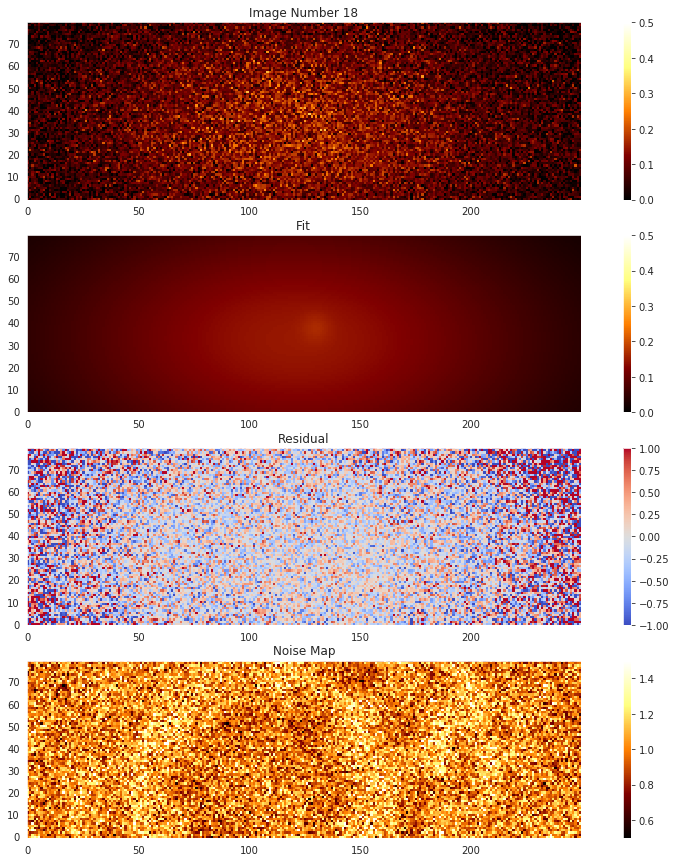

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # data points      = 20000
    # variables        = 10
    chi-square         = 45.5921967
    reduced chi-square = 0.00228075
    Akaike info crit   = -121655.019
    Bayesian info crit = -121575.985
[[Variables]]
    amplitude1:  0.15173023 +/- 8.7166e-04 (0.57%) (init = 0.1)
    xo1:         31.7723714 +/- 0.34925263 (1.10%) (init = 30)
    yo1:         119.439497 +/- 0.42533354 (0.36%) (init = 120)
    sigma_x1:    42.1643045 +/- 0.61929582 (1.47%) (init = 43)
    sigma_y1:    78.3558429 +/- 0.51585197 (0.66%) (init = 80)
    theta1:     -0.01029394 +/- 0.00830167 (80.65%) (init = 0)
    amplitude2:  0.01247223 +/- 0.00807395 (64.74%) (init = 0)
    xo2:         40.9999813 +/- 5.80126180 (14.15%) (init = 38)
    yo2:         133.402908 +/- 2.92831704 (2.20%) (init = 133)
    sigma_x2:    4.45106575 +/- 2.13538384 (47.97%) (init = 2)
    sigma_y2:    4.45106575 +/- 

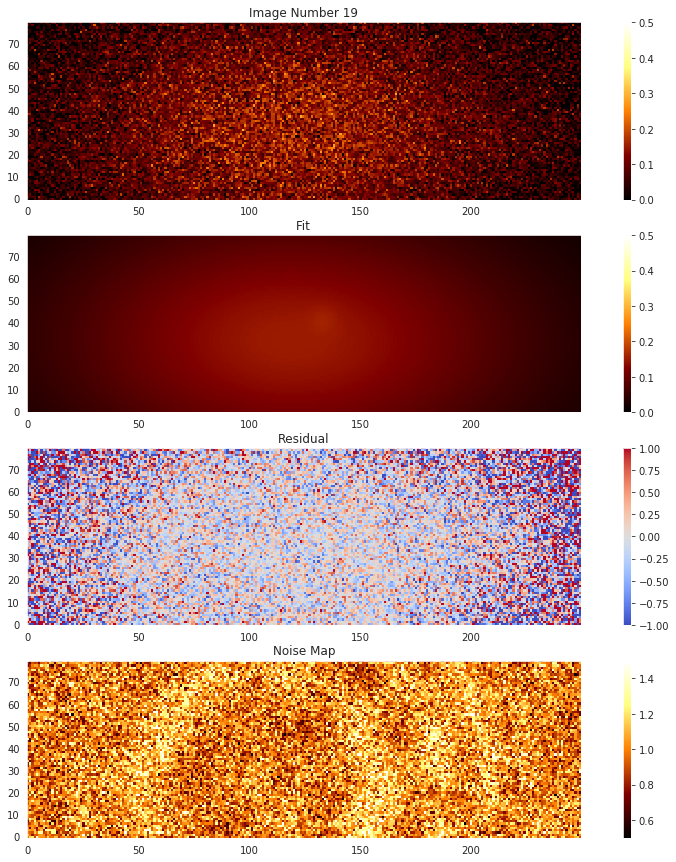

[[Model]]
    Model(two_Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 20000
    # variables        = 10
    chi-square         = 46.5163857
    reduced chi-square = 0.00232698
    Akaike info crit   = -121253.658
    Bayesian info crit = -121174.624
[[Variables]]
    amplitude1:  0.14562524 +/- 8.3609e-04 (0.57%) (init = 0.1)
    xo1:         32.2214692 +/- 0.36173381 (1.12%) (init = 30)
    yo1:         119.124242 +/- 0.44898924 (0.38%) (init = 120)
    sigma_x1:    42.4934882 +/- 0.64922653 (1.53%) (init = 43)
    sigma_y1:    78.9151008 +/- 0.54021585 (0.68%) (init = 80)
    theta1:     -0.01151991 +/- 0.00873855 (75.86%) (init = 0)
    amplitude2:  0.02788481 +/- 0.01546663 (55.47%) (init = 0)
    xo2:         37.7398876 +/- 1.23659677 (3.28%) (init = 38)
    yo2:         131.213129 +/- 1.21918519 (0.93%) (init = 133)
    sigma_x2:    2.00000051 +/- 0.39843602 (19.92%) (init = 2)
    sigma_y2:    2.00000051 +/- 0.

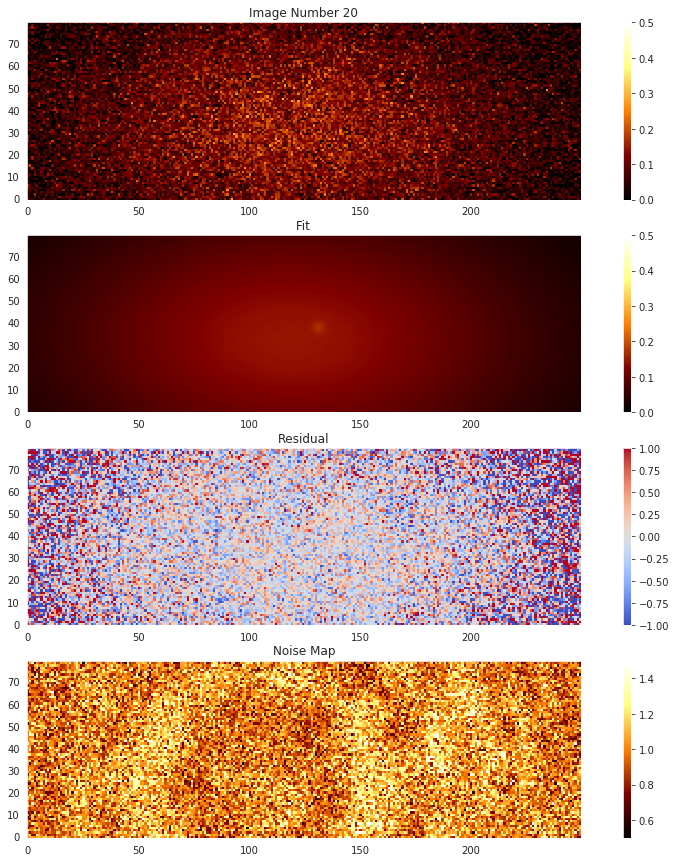

In [15]:
results=list()

model_twoG = Model(two_Gaussian)

params = Parameters()

params = model_twoG.make_params()


'''
    amplitude1:  0.18394255 +/- 9.9664e-04 (0.54%) (init = 0.1)
    xo1:         31.7969773 +/- 0.31891482 (1.00%) (init = 35)
    yo1:         120.607339 +/- 0.36098957 (0.30%) (init = 130)
    sigma_x1:    44.2655891 +/- 0.60387221 (1.36%) (init = 43)
    sigma_y1:    79.6212048 +/- 0.46115742 (0.58%) (init = 80)
    theta1:     -0.02244495 +/- 0.00761270 (33.92%) (init = 0)
    amplitude2: -0.07310095 +/- 0.00475079 (6.50%) (init = 0)
    xo2:         38.6078192 +/- 0.50199385 (1.30%) (init = 43)
    yo2:         134.000010 +/- 1.26573561 (0.94%) (init = 140)
    sigma_x2:    7.99999978 +/- 0.06733817 (0.84%) (init = 2)
    sigma_y2:    7.99999978 +/- 0.06733817 (0.84%) == 'sigma_x2'
'''

# cloud distribution
params.add('amplitude1',value=0.1)
params.add('yo1',value=120*binning_scale,min=100*binning_scale,max=200*binning_scale)
params.add('xo1',value=30*binning_scale,min=20*binning_scale,max=60*binning_scale)
params.add('sigma_x1',value=43*binning_scale,min=20*binning_scale,max=100*binning_scale)
params.add('sigma_y1',value=80*binning_scale,min=20*binning_scale,max=100*binning_scale)
params.add('theta1',value=0,min=-np.pi/10,max=np.pi/10)

# EIT/Autler-Townes-dip
params.add('amplitude2',value=0.00,min=-1,max=1)
params.add('yo2',value=133*binning_scale,min=130*binning_scale,max=136*binning_scale)
params.add('xo2',value=38*binning_scale,min=35*binning_scale,max=41*binning_scale)
params.add('sigma_x2',value=2*binning_scale,min=2*binning_scale,max=10*binning_scale)
#params.add('sigma_y2',value=10,min=3,max=15)
params.add('sigma_y2',expr='sigma_x2')
params.add('theta2',value=0,min=0,max=np.pi,vary=False)

# offset
params.add('offset',value=0,vary=False)
bg_mean,bg_std = make_background(N)

model=model_twoG


for n in range(0,len(variables)):
    bg,std= make_background(N)
    image = fitsopen_bg(n,bg)
    image_weights=fitsopen_std(n)
    #image_weights=gaussian_filter(image_weights, 1, order=0, output=None, mode='nearest', cval=0.0, truncate=4.0)
    #image =  gaussian_filter(image, 1, order=0, output=None, mode='nearest', cval=0.0, truncate=4.0)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten() 
    weights_flat=image_weights.flatten()
    out = model.fit(image_flat,params,weights=weights_flat,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(4,1,figsize=(15,15))
    results.append(copy.deepcopy(out))
    #params = out.params
    #out.params.pretty_print()
    print(out.fit_report())
    #print(out.success)
    vmax = 0.5
    ax[0].set_title('Image Number '+str(n))
    ax[0].imshow(image, origin='bottom',vmin=0, vmax=vmax)
    fig.colorbar(ax[0].imshow(image, origin='bottom',vmin=0, vmax=vmax),ax=ax[0])
    ax[1].set_title('Fit')
    ax[1].imshow(out.best_fit.reshape(shape),origin='bottom',vmin=0, vmax=vmax)
    fig.colorbar(ax[1].imshow(out.best_fit.reshape(shape),origin='bottom',vmin=0, vmax=vmax),ax=ax[1])
    ax[2].set_title('Residual')
    ax[2].imshow((image-out.best_fit.reshape(shape))/out.best_fit.reshape(shape),origin='bottom',vmin=-1, vmax=1, cmap='coolwarm')
    fig.colorbar(ax[2].imshow((image-out.best_fit.reshape(shape))/out.best_fit.reshape(shape),origin='bottom',vmin=-1, vmax=1, cmap='coolwarm') ,ax=ax[2])   
    ax[3].set_title('Noise Map')
    ax[3].imshow(1/image_weights,origin='bottom',vmin=0.5, vmax=1.5, cmap='afmhot')
    fig.colorbar(ax[3].imshow(1/image_weights,origin='bottom',vmin=0.5, vmax=1.5, cmap='afmhot'), ax=ax[3])

    plt.show()

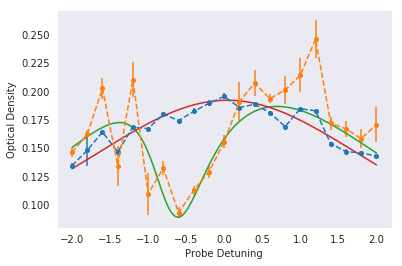

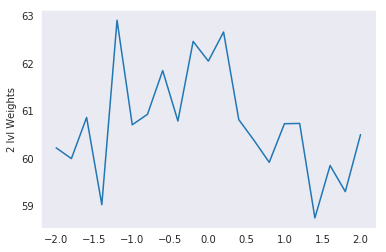

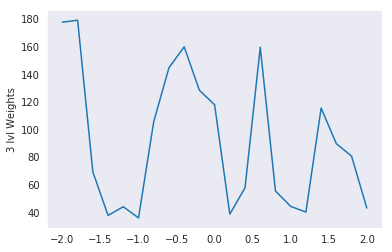

[[Model]]
    Model(ThreeLvlTrans)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 21
    # variables        = 2
    chi-square         = 4.66253220
    reduced chi-square = 0.24539643
    Akaike info crit   = -27.6042387
    Bayesian info crit = -25.5151938
[[Variables]]
    Dp0:           0.04202384 +/- 0.05516439 (131.27%) (init = 0)
    Dc:            0 (fixed)
    g31:           6.02 (fixed)
    g21:           2 (fixed)
    Wc:            0 (fixed)
    density:       4 (fixed)
    wavelength:    0.78 (fixed)
    mediumlength:  13.1439141 +/- 0.13822865 (1.05%) (init = 25)
    redlw:         0 (fixed)
    Wp:            0.1 (fixed)

[[Model]]
    Model(ThreeLvlTrans)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 21
    # variables        = 3
    chi-square         = 51.8336260
    reduced chi-square = 2.87964589
    Akaike info crit   = 24.9738497
    Bayesian info c

In [16]:
Twolevel = [model_twoG.eval(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0]-r.params['amplitude2'].value  for r in results]
#Twolevel = [r.params['amplitude1'].value  for r in results]
#Twolevel= [r.eval(r.params,xy_mesh=(r.params['xo1'].value,r.params['yo1'].value))[0] for r in results]
Threelevel = [r.eval(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0] for r in results]
error2lvl= [r.eval_uncertainty(r.params,xy_mesh=(r.params['xo1'].value,r.params['yo1'].value))[0] for r in results]
error3lvl= [r.eval_uncertainty(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0] for r in results]
weight2lvl= [r.redchi*2.6*10**4 for r in results]
weight3lvl= [1/(1.5*r.eval_uncertainty(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0]) for r in results]

def TwoLvlTrans(Dp,Dp0,g31,mediumlength,wavelength,density,redlw,Wp):
    """
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    Wc=0
    g21=0
    Dp=Dp-Dp0
    prefactor=6.827*10**(-4)
    l=g31/2/( Dp**2 + (g31/2)**2 )
    l1=np.imag(g31*(-2*Dp+1.j*(g31+redlw))/(2 * Wp**2 *(g31+redlw)/g31 + (g31+redlw)**2 +4*Dp**2))/np.pi
    l2=(8* Dp**2 *g31) / abs((g31+1.j*2*Dp)*(1.j*2*Dp))**2
    return 2*mediumlength*(2*np.pi/wavelength)*prefactor*density*l

def ThreeLvlTrans(Dp,Dp0,Dc,g31,g21,Wc,density,wavelength,mediumlength):
    """
    Imaginary Part of the first order susceptibility
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    Dp=Dp-Dp0
    d = Dp-Dc
    prefactor=6.827*10**(-4)
    lside=0#(4*d*(Wc**2 - 4*d*Dp)-4*Dp*g21**2) / abs(Wc**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2
    rside=1.j*(8* d**2 *g31+2*g21*(Wc**2 + g21*g31)) / abs(Wc**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2
    
    return 2*mediumlength*(2*np.pi/wavelength)*np.imag(prefactor*density*(lside+rside))

modelL = Model(ThreeLvlTrans,independent_vars=['Dp'])
paramsL = modelL.make_params()
paramsL.add('wavelength',value=0.78,vary=False)
paramsL.add('mediumlength',value=25,vary=True)
paramsL.add('density',value=4,vary=False)
paramsL.add('redlw',value=0,vary=False)
paramsL.add('Wp',value=0,min=0.1,max=1,vary=False)


paramsL.add('g31',value=6.02,min=4,max=8,vary=False)
paramsL.add('Dp0',value=0,min=-1,max=1,vary=True)
paramsL.add('g21',value=10,min=0,max=2,vary=False)
paramsL.add('Wc',value=0,vary=False)

paramsL.add('Dc',value=0,min=-1,max=1,vary=False)

outL = modelL.fit(Twolevel,params=paramsL,weights=weight2lvl,Dp=variables)#,nan_policy='propagate')


Threelevel = [r.eval(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0] for r in results]



model_ThreeLvlTrans = Model(ThreeLvlTrans,independent_vars=['Dp'])
params_ThreeLvlTrans = model_ThreeLvlTrans.make_params()
params_ThreeLvlTrans.add('wavelength',value=outL.params['wavelength'].value,vary=False)
params_ThreeLvlTrans.add('mediumlength',value=outL.params['mediumlength'].value,vary=False)
params_ThreeLvlTrans.add('density',value=outL.params['density'].value,vary=False)

params_ThreeLvlTrans.add('g31',value=outL.params['g31'].value,min=5,max=7,vary=False)
params_ThreeLvlTrans.add('g21',value=0.0,min=0,max=1.3,vary=True)
params_ThreeLvlTrans.add('Wc',value=1.5,min=0.5,max=2.5,vary=True)

params_ThreeLvlTrans.add('Dc',value=0,min=-1,max=1,vary=True)
params_ThreeLvlTrans.add('Dp0',value=outL.params['Dp0'].value,min=-1,max=1,vary=False)
#params_ThreeLvlTrans.add('Dp',value=0.00)

out = model_ThreeLvlTrans.fit(Threelevel,params=params_ThreeLvlTrans,weights=weight2lvl,Dp=variables)#,nan_policy='omit')

v = np.linspace(min(variables),max(variables),200)

#y = [1-np.exp(-r.params['amplitude1'].value) for r in results]
#x = od_2
#y = (1-np.exp(-od_3))/(1-np.exp(-od_2)) 
#plt.errorbar(x,y,yerr=yerr,marker='o',linestyle='',markersize='4')

#plt.plot(v[50:150],model_ThreeLvlTrans.eval(params_ThreeLvlTrans,Dp=v)[50:150])
#plt.errorbar(variables[7:23],Twolevel[7:23],yerr=error[7:23],marker='o',linestyle='--',markersize='4')
#plt.errorbar(variables[7:23],Threelevel[7:23],yerr=error[7:23],marker='o',linestyle='--',markersize='4')
#plt.plot(v[50:150],model_ThreeLvlTrans.eval(out.params,Dp=v)[50:150])
#plt.plot(v[50:150],modelL.eval(outL.params,Dp=v)[50:150])

#plt.plot(v,model_ThreeLvlTrans.eval(params_ThreeLvlTrans,Dp=v))
#plt.plot(v,modelL.eval(paramsL,Dp=v))
plt.errorbar(variables,Twolevel,yerr=error2lvl,marker='o',linestyle='--',markersize='4')
plt.errorbar(variables,Threelevel,yerr=error3lvl,marker='o',linestyle='--',markersize='4')
plt.plot(v,model_ThreeLvlTrans.eval(out.params,Dp=v))
plt.plot(v,modelL.eval(outL.params,Dp=v))

plt.xlabel("Probe Detuning")
plt.ylabel("Optical Density")
plt.savefig("EIT.svg")
plt.show()

plt.ylabel("2 lvl Weights")
plt.plot(variables,weight2lvl)
plt.show()

plt.ylabel("3 lvl Weights")
plt.plot(variables,weight3lvl)
plt.show()



%notebook -e analysis.ipynb
print(outL.fit_report())
print(out.fit_report())
#print("2 LEVEL RESPONSE")
#outL.params.pretty_print()
#print("3 LEVEL RESPONSE")
#out.params.pretty_print()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.]
9.001079213793494


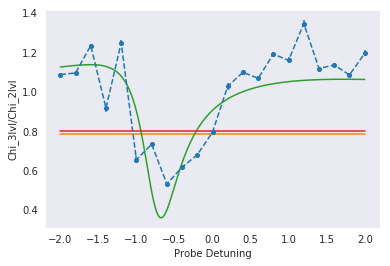

In [19]:
ThreeDivTwolevel = [r.eval(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0]/
                    (model_twoG.eval(r.params,xy_mesh=(r.params['xo2'].value,r.params['yo2'].value))[0]-r.params['amplitude2'].value)  for r in results]
#Twolevel = [r.params['amplitude1'].value  for r in results]
#Twolevel= [r.eval(r.params,xy_mesh=(r.params['xo1'].value,r.params['yo1'].value))[0] for r in results]

v = np.linspace(min(variables),max(variables),200)

def ThreeOverTwo(Dint,g31,Wc,Wp,redlw):
    """
    Imaginary Part of the first order susceptibility
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    """
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """ 
    
    l=4 * redlw * Dint**2 *(g31*redlw+2*Wp)
    l1=(Wp**2+Wc**2)*(g31*Wc**2+redlw*Wp**2)
    return l/(l+l1)

def ThreeTwoTrans(Dp,Dp0,Dc,g31,g21,Wc):
    """
    Imaginary Part of the first order susceptibility
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    Dp=Dp-Dp0
    d = Dp-Dc
    prefactor=6.827*10**(-4)
    lside=0#(4*d*(Wc**2 - 4*d*Dp)-4*Dp*g21**2) / abs(Wc**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2
    rside=(8* d**2 *g31+2*g21*(Wc**2 + g21*g31)) / abs(Wc**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2
    r1=(8* d**2 *g31+2*10*(10*g31)) / abs((g31+1.j*2*Dp)*(10+1.j*2*d))**2
    
    return rside/r1

    
model32 = Model(ThreeTwoTrans,independent_vars=['Dp'])
params32 = modelL.make_params()
params32.add('g31',value=6.02,min=4,max=8,vary=False)
params32.add('Dp0',value=0,min=-1,max=1,vary=False)
params32.add('g21',value=0.1,min=0,max=2,vary=False)
params32.add('Wc',value=1.5,vary=True)
params32.add('Dc',value=-0.14,min=-1,max=1,vary=False)

finalweights=np.ones(len(variables))
for n in range(11,19):
    finalweights[n]=0
print(finalweights)

#out32 = model32.fit(Twolevel,params=params32,weights=finalweights,Dp=variables)#,nan_policy='propagate')

#print(out32.fit_report())


plt.xlabel("Probe Detuning")
plt.ylabel("Chi_3lvl/Chi_2lvl")
plt.errorbar(variables,ThreeDivTwolevel,yerr=error3lvl,marker='o',linestyle='--',markersize='4')

##plt.plot(v,model32.eval(out32.params,Dp=v))

Dp=0
Dp0=0
Dc=-0.7
g31=6.02
g21=0.1
Wc=1.5
density=4
wavelength=0.78
mediumlength=24.6

C6=513000
g21=0.2
redlw=0.2
Wc=1.5
Wp=0.28
g31=6.02
N=4
density=0.004
rb=(2*C6/(g21*redlw+Wc**2))**(1/6)
vb=4/3*np.pi*rb**3
Dint=C6/rb**6*(density*vb/N)**2

print(Dint)

plt.plot(v,np.ones(200)*ThreeOverTwo(Dint,6.02,1.5,0.28,redlw))

plt.plot(v,np.ones(200)*ThreeLvlTrans(v,Dp0,Dc,g31,g21,Wc,density,wavelength,mediumlength)/ThreeLvlTrans(v,Dp0,Dc,g31,100,0,density,wavelength,mediumlength))



plt.plot(v,np.ones(200)*(0.0+4)/(1+4))


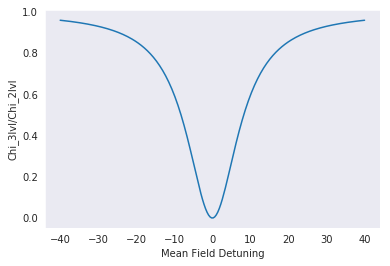

In [418]:

v = np.linspace(-40,40,200)
plt.xlabel("Mean Field Detuning")
plt.ylabel("Chi_3lvl/Chi_2lvl")

plt.plot(v,ThreeOverTwo(v,6.02,1.5,0.28,0.1))



4
0.7836005880024924


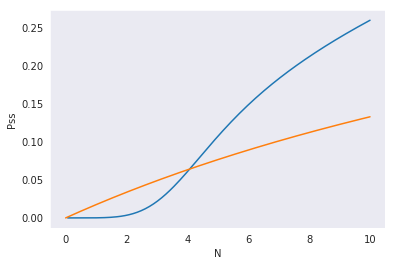

In [533]:
def Pss(N,g21,Wc,C6,density,Wp,redlw):
    rb=(2*C6/(g21*redlw+Wc**2))**(1/6)
    vb=4/3*np.pi*rb**3
    Dint=C6/rb**6*(density*vb/N)**2
    rho_0=(Wp/Wc)**2
    rho=(1-ThreeOverTwo(Dint,g31,Wc,Wp,redlw))
    return rho*rho_0 * N/(rho*rho_0*N+1-rho*rho_0)

def Pss_no_int(N,Wc,Wp):
    rho_0=(Wp/Wc)**2
    return rho_0 * N/(rho_0*N+1-rho_0)




v = np.linspace(0,10,150)

plt.xlabel("N")
plt.ylabel("Pss")


#plt.plot(v,Pss_int(v,0.02,1.5,20,0.004,0.28,0.1))
plt.plot(v,Pss(v,0.02,1.5,513000,0.004,0.28,0.1))
plt.plot(v,0.5*Pss_no_int(v,1.5,0.28))



C6=513000
g21=0.2
redlw=0.2
Wc=1.5
Wp=0.28
g31=6.02
N=4
density=0.004
rb=(2*C6/(g21*redlw+Wc**2))**(1/6)
vb=4/3*np.pi*rb**3
Dint=C6/rb**6*(density*vb/N)**2
print(N)
print(ThreeOverTwo(Dint,g31,Wc,Wp,redlw))
